In [5]:
import torch
import custom_model
import glm3_tokenizer

tokenizer = glm3_tokenizer.GLM3Tokenizer()
config = custom_model.CustomModelConfig(
            vocab_size=tokenizer.vocab_size(),
            padding_token_id=tokenizer.token_pad_id,
            max_position_embeddings=4096,
            hidden_size=704,
            num_heads=16,
            MLP_intermediate=5000,
            num_layers=28,
            attention_dropout=0.1,
            dtype=torch.bfloat16,
            training=True,
            linear_imp = torch.nn.Linear
        )

config.get_total_params()

embedding ratio: 0.1030929639406133
layers ratio: 0.7938124810060924
  * attn size ratio: 0.1254560526721942
  * MLP ratio: 0.6682673260237617
lm_head ratio: 0.1030929639406133
total:442457664 (~442M)


442457664

In [91]:
import torch
import pretrain
from friendly_num import friendly_num

trainer = pretrain.Trainer()

print("token_consumed:", friendly_num(trainer.token_consumed))

tokenizer = trainer.tokenizer
model = trainer.model
model.requires_grad_ = False

embedding ratio: 0.07983494067795566
layers ratio: 0.8403288864902961
  * attn size ratio: 0.10093803868223616
  * MLP ratio: 0.7392922755046594
lm_head ratio: 0.07983494067795566
total:415532544 (~415M)
415532544
checkpoints found! resume!
token_consumed: 17.70M


In [92]:
input_text = "中兴手机"

encoded = tokenizer.encode(input_text)
input_ids = encoded.input_ids
attn_mask = encoded.attention_mask

start_seq_length = len(input_ids[0])

generate_length = 100
final_length = start_seq_length + generate_length

input_ids_tensor = torch.zeros((1, final_length), dtype=tokenizer.dtype).to('cuda')
attn_mask_tensor = torch.zeros((1, final_length), dtype=tokenizer.dtype).to('cuda')

input_ids_tensor[0][:start_seq_length] = input_ids[0]
attn_mask_tensor[0][:start_seq_length] = attn_mask[0]

index = start_seq_length - 1

while index < final_length - 1:
    logits = model.forward(input_ids_tensor, attn_mask_tensor)
    maxed = model.aggressive_decode(logits)
    input_ids_tensor[0][index + 1] = maxed[0][index]
    attn_mask_tensor[0][index + 1] = 1
    index += 1

print("test input:", input_text)
print("test out:", tokenizer.decode(input_ids_tensor))
# print(input_ids_tensor)
# print(attn_mask_tensor)

test input: 中兴手机
test out: ['中兴手机，，']


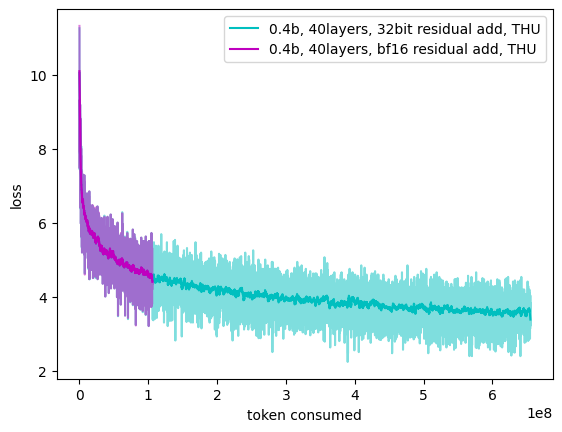

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import os
import json
import torch

def padded_avg(a: torch.Tensor, window_size: int):
    a = torch.vstack([a])
    assert window_size % 2 == 1
    bz = a.shape[0]
    pad_size = int(window_size // 2)
    start_pad = torch.ones((bz, pad_size)) * a[:, :1]
    end_pad = torch.ones((bz, pad_size)) * a[:, -1:]
    concat = torch.concat((start_pad, a, end_pad), dim=-1)
    return torch.nn.functional.avg_pool1d(concat, kernel_size=window_size, stride=1, padding=0)[0]

def get_training_log(saves_dir):
    checkpoints = list(map(lambda x: x.name, os.scandir(saves_dir)))
    checkpoints = sorted(checkpoints, key=lambda x: int(x.split('-')[1]), reverse=False)

    log_entries = []

    for dir in checkpoints:
        log_path = os.path.join(saves_dir, dir, "logs.json")
        with open(log_path) as file:
            file_entries = json.load(file)
        log_entries += file_entries

    losses = list(map(lambda x: x["loss"], log_entries))
    token_comsumed = [x["token_consumed"] for x in log_entries]
    return torch.tensor(token_comsumed), torch.tensor(losses)

alpha = 0.5
window_size = 41

# colors = list(matplotlib.colormaps['Set1'].colors[:])
colors = ['c', 'r', 'y', 'b', 'm', 'c']

def plot_training_history(label, path):
    color = colors.pop()
    token_comsumed, losses = get_training_log(path)
    plt.plot(token_comsumed, losses, alpha=alpha, color=color)
    plt.plot(token_comsumed, padded_avg(losses, window_size), label=label, alpha=1.0, color=color)

# token_comsumed, losses = get_training_log("/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/old/saves_1e-5")
# plt.plot(token_comsumed, losses, alpha=alpha, label="1e-5")

# token_comsumed, losses = get_training_log("/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/old/saves_3e-5")
# plt.plot(token_comsumed, losses, alpha=alpha, label="3e-5")

# token_comsumed, losses = get_training_log("/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/old/saves_wide_params")
# plt.plot(token_comsumed, losses, alpha=alpha, label="shallow network")

#plot_training_history("shallow-2", "/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/old/saves-shallow-2")
#plot_training_history("bitsandbytes", "/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/old/saves_bitsandbytes_1")
#plot_training_history("0.6b, bf16+l2+new_batch_gen+grad_accu", "/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/old/saves_new_batch_gen")
plot_training_history("0.4b, 40layers, 32bit residual add, THU", "/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/saves_bk2")
plot_training_history("0.4b, 40layers, bf16 residual add, THU", "/home/leo/NLP/from_scratch/experiment/exp_05_custom_model_2/saves")
plt.legend()
plt.xlabel("token consumed")
plt.ylabel("loss")
plt.show()


In [6]:
import torch


class BitLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, dtype=torch.bfloat16) -> None:
        super().__init__()
        self.dtype = dtype
        self._weight = torch.nn.Parameter(torch.empty((out_features, in_features), dtype=dtype))
        self._out_features = out_features
        self._in_features = in_features
        torch.nn.init.kaiming_normal_(self._weight)

        ones = torch.ones(in_features, dtype=self.dtype)
        neg_ones = ones * -1
        self.register_buffer("ones", ones, persistent=False)
        self.register_buffer("neg_ones", neg_ones, persistent=False)

    def forward(self, x: torch.Tensor):
        dim = x.shape[-1]
        sum_weight = torch.sum(self._weight.view(self._out_features * self._in_features))
        gamma = (1 / (self._out_features * self._in_features)) * sum_weight
        w_gamma = self._weight / (gamma + 0.00001)
        round_clip_weight = torch.max(self.neg_ones, torch.min(self.ones, torch.round(w_gamma)))
        return torch.nn.functional.linear(x, round_clip_weight)
    
b = BitLinear(3, 6)
a = torch.randn(2, 2, 3, dtype=torch.bfloat16)
b(a)

# z = torch.zeros(5)
# r = torch.randn(2,5)
# torch.max(r, z)

tensor([[[ 1.2422,  1.2422, -2.4688,  1.2422, -0.0547, -1.2422],
         [-1.3594, -1.3594, -1.1875, -1.3594, -0.0664,  1.3594]],

        [[-3.1875, -3.1875,  0.4062, -3.1875,  2.9375,  3.1875],
         [-2.5000, -2.5000,  1.7188, -2.5000,  2.9375,  2.5000]]],
       dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>)

In [7]:
type(torch.nn.Linear)

type

In [82]:
x = torch.tensor([[[-1., 1], [1, 0]], [[-1., 1], [1, 3]], [[1, 0], [1, 0]]])
w = torch.tensor([[1., 0], [-1, 1], [1, 3]])

def embedding_cosine_similarity(x, w):
    dot = torch.einsum(
        "bij, kj -> bik",
        x, w
    ) # [2, 3]
    eps = 0.00001
    x_mag_inv = torch.rsqrt(x.pow(2).sum(dim=-1, keepdim=False) + eps) # [2]
    w_mag_inv = torch.rsqrt(w.pow(2).sum(dim=-1, keepdim=False) + eps) # [3]
    return dot * torch.einsum("bi,j -> bij", x_mag_inv, w_mag_inv)
    
embedding_cosine_similarity(x, w).argmax(dim=-1)

tensor([[1, 0],
        [1, 2],
        [0, 0]])

In [89]:
torch.tensor([[1., 0], [-1, 1], [1, 3]])[None, :, :]

tensor([[[ 1.,  0.],
         [-1.,  1.],
         [ 1.,  3.]]])